## SAR Asymmetries

TODO

- Find the correct filters

- Plot the 2D wind field at the top

- Kepert model will fail when the validity area is too small (e.g Goni)... Why? Add that to filters? In fact, if the validity area is too small, the radii inside the validity area are affected by the large gradients at the edges of the area. Analytically, the BL depth delta-1 becomes infinite, at a rate 1 / sqrt(I - V/r), when I ~ V/r.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [34]:
def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

palette      = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [35]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/results/sar_extended/03_addIBT/dsg.nc',
    'sar_dir':  '/home/arthur/data/cyclobs/RCM/sar_files/',
    'sav_dir': '/home/arthur/results/winddirection/00_plotSARasymmetries/',
}

In [36]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open data
all_data = glob.glob(PTHS['sar_dir'] + "*.nc")
print('Nb of SAR files = {}'.format(len(all_data)))

Nb of SAR files = 816


In [37]:
# all_data = ['/home/arthur/data/cyclobs/RCM/sar_files/rs2--owi-ca-20201030t211604-20201030t211719-00003-______sw_wp222020_cyclone_polar.nc']
# all_data = ['/home/arthur/data/cyclobs/RCM/sar_files/rcm1--owi-ca-20230809t050027-20230809t050143-00003-______sw_ep052023_cyclone_polar.nc']

In [38]:
for idx, file in tqdm(enumerate(all_data)):
    try: 
        # Open file
        dsp = xr.open_dataset(file).isel(time=0)
        ds  = dsg.where(dsg.file == dsp.attrs['Source satellite file'], drop=True).isel(time=0)

        # Fixed parameters
        vmx = float(ds.vmx)
        rmx = float(ds.rmx)
        vmn = float(ds.vmn)
        B   = float(ds.B_hol)
        lat = float(ds.lat)
        fcr = float(ds.fcor)
        
        # Holland with fixed parameters
        V   = h80(rs, vmx, rmx, B, lat, vmn)
        Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)
        
        # Area of model validity
        try:
            I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
            r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
        except IndexError:
            pass
        
        # Prepare averagings
        timescale   = 1 / I(Rs, Vs, fcr)[0, :] # time needed for the BL to develop
        radialscale = timescale * Vs[0, :] / 5 # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
        tangenscale = timescale * Vs[0, :]     # tangential distance travelled by an air parcel in the meantime
        thetascale  = 360 * tangenscale / (2 * np.pi * rs) # convert this tangential distance to theta
        
        print(idx, ds.file.item())
        
        if (ds.center_quality_flag < 2) & (ds.percent_outside < 10) & (abs(ds.lat) < 30) & (ds.vmx >= 33):
            # x-axis
            xs = np.linspace(ds.rmx, 2 * ds.rps, 50)

            # Asymmetries
            ASS  = []
            AS2  = []
            AS3  = []
            ASQ  = []
            rads = []
            ERR  = []
            for rad in tqdm(xs):
                try:
                    # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
                    # ass, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
                    valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
                    ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
                    error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), ass, phi, c), valid_dsp.wind_speed)) 
                    ASS.append(ass)
                    ERR.append(error)
                    
                    # Preparing averagings
                    avg_on_u = radialscale[rs >= rad][0]
                    avg_on_v = int(thetascale[rs >= rad][0])
                    
                    # Average on theta
                    valid_dsp2      = dsp.sel(rad=rad, method='nearest').rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(subset=['wind_speed'], dim='theta')
                    as2, phi2, c2   = get_wn1(np.deg2rad(valid_dsp2.theta), valid_dsp2.wind_speed, float(ds.vps), float(ds.vmx))
                    AS2.append(as2)

                    # Average on theta AND r
                    valid_dsp3      = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
                    as3, phi3, c3   = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
                    AS3.append(as3)
                    
                    # Add radius
                    rads.append(rad)
                    
                    
                except RuntimeError:
                    break
                # Asymmetries with the quantiles
                a_qtl = dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.9) - dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.1)
                ASQ.append(a_qtl)
                    
            ### Plot
            # First save the SAR image
            dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
            ds_x, ds_y   = pol2cart(dr, th)
            ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='nearest')

            plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
            plt.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer);plt.colorbar()
            plt.xlabel('x (km)');plt.ylabel('y (km)')
            plt.grid()

            plt.savefig(PTHS['sav_dir'] + ds.file.item().split('.')[0] + '_2Dwindfield', bbox_inches='tight', format='png');plt.clf()
              
            # Then plot the asymmetry profiles
            plt.plot(rads, ASS, c='k',          linewidth=3,        label='Amplitude of cosine')
            plt.plot(rads, AS2, c='k',                              label='Amplitude of cosine, avg. on th')
            plt.plot(rads, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
            plt.plot(rads, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
            plt.plot(rads, ASQ, c='tab:blue',   linewidth=3,        label='10%-quantile difference')
            plt.axvline(ds.rmx, c='tab:red',    linewidth=3,        label='Rmax')
            plt.axvline(ds.rps, c='tab:red',    label='R+')
            plt.axvspan(r_stt, r_end, color='tab:green', alpha=0.3, label='Inertial stability area (i.e where model is valid)')
            plt.xlabel('r (m)')
            plt.ylabel('Asymmetry - amplitude of WN1 (m/s)')
            plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
            plt.legend(frameon=False)

            # ### Save
            plt.savefig(PTHS['sav_dir'] + ds.file.item().split('.')[0] + '_asym', bbox_inches='tight', format='png');plt.clf()

    except ValueError:
        print('Value error, file skipped.')

0it [00:00, ?it/s]

0 rs2--owi-cm-20210314t003920-20210314t004036-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

1 s1a-ew-owi-cm-20190320t124952-20190320t125126-000003-02F50E_sw.nc
2 s1a-ew-owi-cm-20231013t080655-20231013t080759-000003-061D67_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
3 s1b-iw-owi-cm-20200921t194728-20200921t194822-000003-02C997_sw.nc
4 s1a-ew-owi-cm-20180807t083104-20180807t083409-000003-028367_sw.nc
5 rs2--owi-cm-20200726t161050-20200726t161314-00003-______sw.nc
6 rs2--owi-cm-20160712t022824-20160712t022940-00003-______sw.nc
7 rs2--owi-cm-20220323t111355-20220323t111619-00003-______sw.nc
8 rs2--owi-cm-20160825t093014-20160825t093130-00003-______sw.nc
9 s1b-ew-owi-cm-20211027t202821-20211027t203105-000003-03800D_sw.nc
10 rcm1--owi-cm-20230125t153532-20230125t153649-00003-______sw.nc
11 s1a-ew-owi-cm-20181013t071546-20181013t071851-000003-02A2E9_sw.nc
12 s1b-iw-owi-cm-20201031t212858-20201031t213128-000003-02DBDB_sw.nc
13 s1a-iw-owi-cm-20191002t080415-20191002t080555-000003-0353A1_sw.nc
14 s1a-ew-owi-cm-20190322t214643-20190322t214850-000003-02F65C_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

15 s1a-ew-owi-cm-20181009t234305-20181009t234610-000003-02A153_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

16 s1a-ew-owi-cm-20210421t093352-20210421t093556-000003-046D8B_sw.nc
17 s1a-ew-owi-cm-20180726t203604-20180726t203909-000003-027E26_sw.nc
18 s1a-iw-owi-cm-20200827t000908-20200827t001138-000003-03F518_sw.nc
19 rcm2--owi-cm-20221022t124742-20221022t124922-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

20 s1b-ew-owi-cm-20180912t081831-20180912t082017-000003-01765A_sw.nc
21 s1a-iw-owi-cm-20230303t072159-20230303t072256-000003-05B333_sw.nc
22 s1b-iw-owi-cm-20181002t013418-20181002t013558-000003-017F30_sw.nc
23 s1b-ew-owi-cm-20191010t085239-20191010t085526-000003-022AE7_sw.nc
24 s1a-ew-owi-cm-20160829t203410-20160829t203614-000003-01437E_sw.nc
25 rcm1--owi-cm-20230629t130417-20230629t130535-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

26 rs2--owi-cm-20220916t210335-20220916t210558-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

27 rs2--owi-cm-20210925t204847-20210925t205110-00003-______sw.nc
28 rs2--owi-cm-20160902t035139-20160902t035544-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

29 rs2--owi-cm-20220923t220719-20220923t220943-00003-______sw.nc
30 s1a-ew-owi-cm-20180925t211906-20180925t212211-000003-029AA3_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

31 s1a-ew-owi-cm-20210927t212900-20210927t213119-000003-04B7A8_sw.nc
32 s1a-iw-owi-cm-20220913t184440-20220913t184557-000003-056002_sw.nc
33 s1a-ew-owi-cm-20180819t032959-20180819t033303-000003-0288F7_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

34 s1a-ew-owi-cm-20230217t002232-20230217t002412-000003-05AC30_sw.nc
35 s1a-ew-owi-cm-20181006t140456-20181006t140700-000003-029FBE_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

36 rcm3--owi-cm-20230518t133754-20230518t133849-00003-______sw.nc
37 rcm2--owi-cm-20221114t071250-20221114t071430-00003-______sw.nc
38 s1a-iw-owi-cm-20180111t212220-20180111t212340-000003-0224B0_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
39 rs2--owi-cm-20210930t095823-20210930t095939-00003-______sw.nc
40 rs2--owi-cm-20170908t105352-20170908t105502-00003-______sw.nc
41 s1a-iw-owi-cm-20180806t011151-20180806t011245-000003-0282CD_sw.nc
42 s1a-ew-owi-cm-20220324t132353-20220324t132628-000003-05105F_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

43 rs2--owi-cm-20201028t120710-20201028t120825-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

44 rs2--owi-cm-20140805t093342-20140805t093535-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

45 rcm1--owi-cm-20230309t030215-20230309t030329-00003-______sw.nc
46 rs2--owi-cm-20210220t030329-20210220t030445-00003-______sw.nc
47 s1a-ew-owi-cm-20160829t214021-20160829t214342-000003-01438B_sw.nc
48 s1a-iw-owi-cm-20170918t221759-20170918t222029-000003-01F0A9_sw.nc
49 rcm2--owi-cm-20210818t143906-20210818t144138-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

50 rcm1--owi-cm-20221108t104306-20221108t104510-00003-______sw.nc
51 s1a-iw-owi-cm-20220309t022620-20220309t022739-000003-0508C0_sw.nc
52 rs2--owi-cm-20201003t141913-20201003t142136-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

53 rs2--owi-cm-20191023t083016-20191023t083348-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

54 s1b-iw-owi-cm-20200915t235233-20200915t235417-000003-02C6F9_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

55 rcm2--owi-cm-20230412t213217-20230412t213332-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

56 s1a-ew-owi-cm-20201026t221102-20201026t221307-000003-041438_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

57 rs2--owi-cm-20220220t143954-20220220t144218-00003-______sw.nc
58 s1a-iw-owi-cm-20210908t100621-20210908t100801-000003-04ADF7_sw.nc
59 s1a-iw-owi-cm-20180815t104101-20180815t104220-000003-02872E_sw.nc
60 rs2--owi-cm-20141013t100142-20141013t100258-00003-______sw.nc
61 rcm3--owi-cm-20221229t003824-20221229t004004-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
62 rcm2--owi-cm-20230309t155937-20230309t160053-00003-______sw.nc
63 s1b-iw-owi-cm-20191208t022442-20191208t022601-000003-024608_sw.nc
64 rcm1--owi-cm-20210219t094038-20210219t094134-00003-______sw.nc
65 s1a-ew-owi-cm-20181004t020906-20181004t021111-000003-029E91_sw.nc
66 rcm3--owi-cm-20230622t092800-20230622t092916-00003-______sw.nc
67 s1a-ew-owi-cm-20180908t040704-20180908t040908-000003-029243_sw.nc
68 s1b-ew-owi-cm-20180308t012234-20180308t012539-000003-011FE5_sw.nc
69 rs2--owi-cm-20170729t083209-20170729t083300-00003-______sw.nc
70 s1a-iw-owi-cm-20180913t221855-20180913t222010-000003-0294F7_sw.nc
71 s1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

72 rs2--owi-cm-20220922t223442-20220922t223705-00003-______sw.nc
73 rcm1--owi-cm-20200623t100843-20200623t100939-00003-______sw.nc
74 rcm3--owi-cm-20201010t084315-20201010t084427-00003-______sw.nc
75 s1b-ew-owi-cm-20190330t135323-20190330t135509-000003-01D369_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

76 rcm3--owi-cm-20230209t221955-20230209t222110-00003-______sw.nc
77 rcm3--owi-cm-20230210t222810-20230210t222926-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

78 s1a-iw-owi-cm-20190914t231126-20190914t231306-000003-034AF8_sw.nc
79 s1a-iw-owi-cm-20170902t133647-20170902t133827-000003-01E94D_sw.nc
80 s1a-ew-owi-cm-20191231t144416-20191231t144620-000003-03813D_sw.nc
81 rcm1--owi-cm-20230815t205303-20230815t205405-00003-______sw.nc
82 s1b-ew-owi-cm-20180728t210603-20180728t210835-000003-0161F6_sw.nc
83 rs2--owi-cm-20220112t065152-20220112t065415-00003-______sw.nc
84 s1a-ew-owi-cm-20230308t154255-20230308t154359-000003-05B5DE_sw.nc
85 s1a-ew-owi-cm-20160827t092124-20160827t092414-000003-014249_sw.nc
86 rs2--owi-cm-20140914t090541-20140914t090657-00003-______sw.nc
87 rcm1--owi-cm-20230809t165811-20230809t165925-00003-______sw.nc
88 rs2--owi-cm-20150602t135643-20150602t135759-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

89 rs2--owi-cm-20141020t163921-20141020t164037-00003-______sw.nc
90 rcm1--owi-cm-20230917t213237-20230917t213354-00003-______sw.nc
91 s1a-iw-owi-cm-20210629t130556-20210629t130711-000003-048CB1_sw.nc
92 s1b-ew-owi-cm-20190503t001255-20190503t001459-000003-01E3AE_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

93 rcm1--owi-cm-20230909t220434-20230909t220551-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

94 rcm3--owi-cm-20230520t135354-20230520t135420-00003-______sw.nc
95 s1b-ew-owi-cm-20210927t090902-20210927t091207-000003-03725C_sw.nc
96 rcm1--owi-cm-20230912t101305-20230912t101421-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

97 rcm1--owi-cm-20230310t030937-20230310t031117-00003-______sw.nc
98 s1b-ew-owi-cm-20201114t103802-20201114t104036-000003-02E20F_sw.nc
99 rs2--owi-cm-20160708t024536-20160708t024652-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

100 s1a-ew-owi-cm-20221229t004058-20221229t004303-000003-0593A7_sw.nc
101 s1a-ew-owi-cm-20160926t093348-20160926t093714-000003-01509C_sw.nc
102 rs2--owi-cm-20151021t152606-20151021t152722-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

103 s1a-ew-owi-cm-20220714t151857-20220714t152046-000003-05438A_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

104 rs2--owi-cm-20150902t201620-20150902t201736-00003-______sw.nc
105 rcm1--owi-cm-20230806t145737-20230806t145855-00003-______sw.nc
106 s1a-iw-owi-cm-20200916t092622-20200916t092738-000003-03FF8D_sw.nc
107 s1b-ew-owi-cm-20180808t082357-20180808t082552-000003-016699_sw.nc
108 s1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

109 rcm3--owi-cm-20230411t101505-20230411t101649-00003-______sw.nc
110 rs2--owi-cm-20150621t104002-20150621t104109-00003-______sw.nc
111 s1b-ew-owi-cm-20190802t042011-20190802t042203-000003-020B9A_sw.nc
112 s1a-ew-owi-cm-20160920t215441-20160920t215724-000003-014E08_sw.nc
113 s1a-ew-owi-cm-20230804t213456-20230804t213559-000003-05FAEB_sw.nc
114 rs2--owi-cm-20150803t202943-20150803t203347-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

115 s1a-ew-owi-cm-20180904t083405-20180904t083710-000003-029075_sw.nc
116 s1a-iw-owi-cm-20190906t224121-20190906t224301-000003-0346EC_sw.nc
117 rcm2--owi-cm-20230521t005919-20230521t010001-00003-______sw.nc
118 s1b-ew-owi-cm-20201225t014342-20201225t014552-000003-02F4F5_sw.nc
119 s1a-iw-owi-cm-20231022t222848-20231022t223011-000003-062224_sw.nc
120 s1a-iw-owi-cm-20231024t004708-20231024t004802-000003-0622AE_sw.nc
121 s1a-iw-owi-cm-20200516t232006-20200516t232121-000003-03C684_sw.nc
122 rs2--owi-cm-20210418t093003-20210418t093118-00003-______sw.nc
123 rs2--owi-cm-20140814t014651-20140814t014807-00003-______sw.nc
124 rcm3--owi-cm-20221103t085346-20221103t085706-00003-______sw.nc
125 s1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

126 rcm3--owi-cm-20230410t100737-20230410t100853-00003-______sw.nc
127 s1a-ew-owi-cm-20190330t005718-20190330t010032-000003-02FA24_sw.nc
128 rs2--owi-cm-20150803t152928-20150803t153044-00003-______sw.nc
129 rs2--owi-cm-20180308t012408-20180308t012739-00003-______sw.nc
130 s1b-ew-owi-cm-20190906t141103-20190906t141249-000003-021B95_sw.nc
131 rs2--owi-cm-20191207t022100-20191207t022324-00003-______sw.nc
132 s1b-iw-owi-cm-20171014t193841-20171014t194046-000003-00DD36_sw.nc
133 rcm1--owi-cm-20211027t222516-20211027t222640-00003-______sw.nc
134 rs2--owi-cm-20141019t044431-20141019t044547-00003-______sw.nc
135 s1a-ew-owi-cm-20180928t093504-20180928t093708-000003-029BC7_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

136 rcm1--owi-cm-20230305t170112-20230305t170229-00003-______sw.nc
137 rcm1--owi-cm-20230614t012242-20230614t012349-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

138 rcm1--owi-cm-20230218t135942-20230218t140057-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

139 s1a-iw-owi-cm-20201009t120643-20201009t120826-000003-040B68_sw.nc
140 rcm1--owi-cm-20210817t100853-20210817t101301-00003-______sw.nc
141 s1a-ew-owi-cm-20190930t210003-20190930t210142-000003-0352F9_sw.nc
142 rcm1--owi-cm-20230128t155750-20230128t155907-00003-______sw.nc
143 s1a-iw-owi-cm-20230806t211820-20230806t211916-000003-05FBCB_sw.nc
144 rcm1--owi-cm-20230223t024649-20230223t024805-00003-______sw.nc
145 s1a-ew-owi-cm-20230214t134626-20230214t134830-000003-05AAE6_sw.nc
146 rs2--owi-cm-20200903t203531-20200903t203902-00003-______sw.nc
147 rcm1--owi-cm-20230809t050027-20230809t050143-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

148 s1a-iw-owi-cm-20220701t104123-20220701t104217-000003-053DCB_sw.nc
149 rs2--owi-cm-20210208t125630-20210208t125746-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

150 s1b-iw-owi-cm-20201026t235804-20201026t235944-000003-02D99A_sw.nc
151 s1b-ew-owi-cm-20190306t135326-20190306t135533-000003-01C808_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

152 s1a-ew-owi-cm-20220219t013628-20220219t013902-000003-04FFB8_sw.nc
153 rs2--owi-cm-20171008t204743-20171008t204859-00003-______sw.nc
154 rcm1--owi-cm-20230303t181918-20230303t182032-00003-______sw.nc
155 rcm2--owi-cm-20230920t212853-20230920t212959-00003-______sw.nc
156 s1a-ew-owi-cm-20201029t205631-20201029t205758-000003-0415BC_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

157 rcm1--owi-cm-20221223t124804-20221223t124948-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

158 s1a-ew-owi-cm-20191105t195730-20191105t195916-000003-03651B_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

159 rs2--owi-cm-20200901t213245-20200901t213508-00003-______sw.nc
160 rcm1--owi-cm-20210902t103929-20210902t104157-00003-______sw.nc
161 s1b-iw-owi-cm-20191119t095826-20191119t095943-000003-023D71_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

162 rs2--owi-cm-20190328t005221-20190328t005444-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

163 rcm2--owi-cm-20220918t010744-20220918t011032-00003-______sw.nc
164 rs2--owi-cm-20210302t231916-20210302t232032-00003-______sw.nc
165 s1b-iw-owi-cm-20180914t111440-20180914t111617-000003-017758_sw.nc
166 rs2--owi-cm-20220730t015650-20220730t015805-00003-______sw.nc
167 rs2--owi-cm-20190930t083654-20190930t083917-00003-______sw.nc
168 s1a-iw-owi-cm-20170818t222630-20170818t222745-000003-01E2E2_sw.nc
169 s1b-ew-owi-cm-20201004t142803-20201004t143007-000003-02CF68_sw.nc
170 rs2--owi-cm-20220130t004632-20220130t004856-00003-______sw.nc
171 rcm2--owi-cm-20230622t221051-20230622t221140-00003-______sw.nc
172 rcm1--owi-cm-20230908t215553-20230908t215709-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

173 s1a-iw-owi-cm-20210628t232129-20210628t232244-000003-048C7A_sw.nc
174 s1a-ew-owi-cm-20230125t024334-20230125t024630-000003-05A0FA_sw.nc
175 s1a-ew-owi-cm-20211026t203818-20211026t204047-000003-04C656_sw.nc
176 rs2--owi-cm-20180807t154512-20180807t154628-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

177 rcm1--owi-cm-20221228t132546-20221228t132754-00003-______sw.nc
178 s1a-ew-owi-cm-20180812t172848-20180812t173053-000003-0285E5_sw.nc
179 s1b-iw-owi-cm-20191012t084028-20191012t084212-000003-022BD1_sw.nc
180 rcm3--owi-cm-20230807t034044-20230807t034200-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

181 rs2--owi-cm-20220414t090200-20220414t090423-00003-______sw.nc
182 s1b-ew-owi-cm-20181004t093407-20181004t093712-000003-018034_sw.nc
183 s1a-ew-owi-cm-20181025t203134-20181025t203308-000003-02A8D5_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

184 rcm3--owi-cm-20220910t094404-20220910t094512-00003-______sw.nc
185 s1b-iw-owi-cm-20170704t085708-20170704t085805-000003-00B237_sw.nc
186 rcm1--owi-cm-20230817t025319-20230817t025435-00003-______sw.nc
187 rcm3--owi-cm-20230220t011738-20230220t011826-00003-______sw.nc
188 s1a-ew-owi-cm-20160830t094412-20160830t094716-000003-0143C4_sw.nc
189 s1a-iw-owi-cm-20220510t002224-20220510t002319-000003-052704_sw.nc
190 s1a-iw-owi-cm-20221014t002357-20221014t002537-000003-056EC6_sw.nc
191 s1a-ew-owi-cm-20230908t092521-20230908t092624-000003-060BF1_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

192 rcm1--owi-cm-20230331t112651-20230331t112806-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

193 s1a-ew-owi-cm-20200725t034755-20200725t035002-000003-03E50E_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

194 rs2--owi-cm-20130701t104119-20130701t104235-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

195 rs2--owi-cm-20150903t152310-20150903t152714-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

196 rs2--owi-cm-20180803t142144-20180803t142259-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

197 rs2--owi-cm-20200831t094052-20200831t094316-00003-______sw.nc
198 rs2--owi-cm-20150906t185705-20150906t185821-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

199 rcm3--owi-cm-20220904t215128-20220904t215227-00003-______sw.nc
200 s1a-ew-owi-cm-20210307t144420-20210307t144624-000003-0456E5_sw.nc
201 s1a-ew-owi-cm-20231011t203059-20231011t203203-000003-061CAB_sw.nc
202 s1a-ew-owi-cm-20190301t062053-20190301t062258-000003-02EAC0_sw.nc
203 rcm1--owi-cm-20211010t123945-20211010t124209-00003-______sw.nc
204 s1b-iw-owi-cm-20210806t215140-20210806t215226-000003-035B26_sw.nc
205 rcm3--owi-cm-20220922t010756-20220922t011044-00003-______sw.nc
206 s1a-iw-owi-cm-20230908t215511-20230908t215716-000003-060C3F_sw.nc
207 rcm3--owi-cm-20230330t222809-20230330t222926-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

208 s1a-ew-owi-cm-20190928t084309-20190928t084413-000003-0351A9_sw.nc
209 rs2--owi-cm-20200917t212905-20200917t213236-00003-______sw.nc
210 rs2--owi-cm-20190801t143241-20190801t143612-00003-______sw.nc
211 rcm2--owi-cm-20230913t203204-20230913t203320-00003-______sw.nc
212 rcm1--owi-cm-20230907t214712-20230907t214830-00003-______sw.nc
213 rcm3--owi-cm-20230624t215539-20230624t215655-00003-______sw.nc
214 s1a-ew-owi-cm-20171014t074902-20171014t075202-000003-01FBF4_sw.nc
215 s1a-iw-owi-cm-20170504t071401-20170504t071505-000003-01B35C_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

216 s1a-ew-owi-cm-20230828t223927-20230828t224031-000003-0606CB_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

217 rs2--owi-cm-20160920t215512-20160920t215843-00003-______sw.nc
218 rcm3--owi-cm-20200830t013418-20200830t013550-00003-______sw.nc
219 rs2--owi-cm-20150510t215025-20150510t215141-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

220 s1a-ew-owi-cm-20160904t092033-20160904t092333-000003-014632_sw.nc
221 rs2--owi-cm-20140717t102721-20140717t102909-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

222 rs2--owi-cm-20220918t092524-20220918t092747-00003-______sw.nc
223 rcm1--owi-cm-20230528t094334-20230528t094451-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

224 s1a-iw-owi-cm-20210418t212223-20210418t212342-000003-046C42_sw.nc
225 s1a-ew-owi-cm-20180908t161305-20180908t161509-000003-029283_sw.nc
226 s1b-ew-owi-cm-20210829t125731-20210829t125905-000003-036572_sw.nc
227 rcm1--owi-cm-20230911t204541-20230911t204657-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

228 rs2--owi-cm-20171021t092057-20171021t092213-00003-______sw.nc
229 s1a-ew-owi-cm-20160827t205158-20160827t205454-000003-014285_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

230 s1a-ew-owi-cm-20160923t222132-20160923t222431-000003-014F7C_sw.nc
231 s1a-ew-owi-cm-20160920t092323-20160920t092627-000003-014DC9_sw.nc
232 rcm1--owi-cm-20220926t112558-20220926t112806-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

233 rcm1--owi-cm-20230909t081338-20230909t081454-00003-______sw.nc
234 s1a-ew-owi-cm-20180203t130526-20180203t130830-000003-022F35_sw.nc
235 rs2--owi-cm-20191114t201229-20191114t201344-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

236 rcm1--owi-cm-20210808t082812-20210808t082944-00003-______sw.nc
237 rcm1--owi-cm-20230913t084207-20230913t084324-00003-______sw.nc
238 rcm2--owi-cm-20230212t231540-20230212t231720-00003-______sw.nc
239 rcm2--owi-cm-20230308t155113-20230308t155229-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

240 s1a-ew-owi-cm-20160904t223153-20160904t223504-000003-01467A_sw.nc
241 s1a-ew-owi-cm-20190731t034721-20190731t034910-000003-033442_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

242 s1a-ew-owi-cm-20181010t114907-20181010t115212-000003-02A192_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

243 s1a-iw-owi-cm-20220907t133107-20220907t133151-000003-055CF5_sw.nc
244 s1a-iw-owi-cm-20220916t221920-20220916t222035-000003-056188_sw.nc
245 s1b-ew-owi-cm-20200728t050249-20200728t050456-000003-02B05B_sw.nc
246 s1a-ew-owi-cm-20181003t134006-20181003t134210-000003-029E52_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

247 s1b-ew-owi-cm-20190929t210610-20190929t210814-000003-02261A_sw.nc
248 rs2--owi-cm-20220326t004133-20220326t004249-00003-______sw.nc
249 s1b-ew-owi-cm-20190224t085010-20190224t085218-000003-01C31C_sw.nc
250 rcm2--owi-cm-20201009t205425-20201009t205537-00003-______sw.nc
251 s1a-ew-owi-cm-20200919t081237-20200919t081514-000003-040117_sw.nc
252 rs2--owi-cm-20170804t211741-20170804t211857-00003-______sw.nc
253 s1a-ew-owi-cm-20230906t090446-20230906t090549-000003-060AF0_sw.nc
254 rcm1--owi-cm-20230224t025500-20230224t025617-00003-______sw.nc
255 s1b-iw-owi-cm-20201020t095807-20201020t095922-000003-02D69A_sw.nc
256 s1b-ew-owi-cm-20190218t184446-20190218t184711-000003-01C08C_sw.nc
257 rs2--owi-cm-20160925t092440-20160925t092703-00003-______sw.nc
258 rs2--owi-cm-20211026t204501-20211026t204724-00003-______sw.nc
259 rs2--owi-cm-20220720t014938-20220720t015054-00003-______sw.nc
260 rcm1--owi-cm-20230330t111910-20230330t112038-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

261 s1a-iw-owi-cm-20210823t161535-20210823t161654-000003-04A612_sw.nc
262 rs2--owi-cm-20180829t150350-20180829t150506-00003-______sw.nc
263 rs2--owi-cm-20220705t004424-20220705t004648-00003-______sw.nc
264 rs2--owi-cm-20210517t010128-20210517t010351-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

265 s1a-iw-owi-cm-20201103t234046-20201103t234226-000003-04184A_sw.nc
266 rs2--owi-cm-20220904t093255-20220904t093518-00003-______sw.nc
267 s1a-ew-owi-cm-20160830t144512-20160830t144658-000003-0143DB_sw.nc
268 s1a-ew-owi-cm-20200922t101602-20200922t101906-000003-0402C5_sw.nc
269 rs2--owi-cm-20150906t045900-20150906t050016-00003-______sw.nc
270 s1a-ew-owi-cm-20180905t034104-20180905t034309-000003-0290D7_sw.nc
271 s1a-ew-owi-cm-20210924t210331-20210924t210556-000003-04B621_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

272 rs2--owi-cm-20180117t144402-20180117t144733-00003-______sw.nc
273 rcm2--owi-cm-20230213t232405-20230213t232520-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

274 rcm2--owi-cm-20230804t140912-20230804t141028-00003-______sw.nc
275 s1a-ew-owi-cm-20230819t013753-20230819t013856-000003-0601D3_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

276 s1a-ew-owi-cm-20201027t103902-20201027t104036-000003-04147D_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

277 s1a-ew-owi-cm-20230815t085014-20230815t085117-000003-05FFFE_sw.nc
278 rcm1--owi-cm-20210907t091103-20210907t091211-00003-______sw.nc
279 s1a-iw-owi-cm-20200821t221932-20200821t222047-000003-03F28D_sw.nc
280 s1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

281 s1b-ew-owi-cm-20190331t004928-20190331t005133-000003-01D3A6_sw.nc
282 s1a-ew-owi-cm-20231010t131515-20231010t131619-000003-061BFB_sw.nc
283 s1a-iw-owi-cm-20160901t234439-20160901t234559-000003-01450E_sw.nc
284 s1a-iw-owi-cm-20190831t105329-20190831t105448-000003-03439C_sw.nc
285 s1a-iw-owi-cm-20230614t012641-20230614t012816-000003-05E3BE_sw.nc
286 s1a-iw-owi-cm-20180316t204737-20180316t204852-000003-024251_sw.nc
287 s1a-iw-owi-cm-20210721t213527-20210721t213718-000003-049689_sw.nc
288 s1a-ew-owi-cm-20190706t030714-20190706t030900-000003-03292B_sw.nc
289 s1a-iw-owi-cm-20231022t131347-20231022t131505-000003-0621EC_sw.nc
290 rcm1--owi-cm-20230820t133314-20230820t133432-00003-______sw.nc
291 s1a-ew-owi-cm-20190904t133932-20190904t134121-000003-0345B8_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

292 s1a-ew-owi-cm-20181009t142906-20181009t143110-000003-02A122_sw.nc
293 s1b-ew-owi-cm-20190309t141317-20190309t141622-000003-01C976_sw.nc
294 rs2--owi-cm-20160712t131319-20160712t131723-00003-______sw.nc
295 s1b-ew-owi-cm-20180901t032311-20180901t032613-000003-01715C_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

296 rcm3--owi-cm-20221231t005630-20221231t005810-00003-______sw.nc
297 s1b-iw-owi-cm-20170918t082654-20170918t082747-000003-00D23F_sw.nc
298 s1a-iw-owi-cm-20170921t224421-20170921t224626-000003-01F204_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

299 s1b-ew-owi-cm-20190321t201403-20190321t201625-000003-01CF41_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

300 s1a-ew-owi-cm-20220201t143621-20220201t143926-000003-04F6DD_sw.nc
301 rcm2--owi-cm-20230302t065950-20230302t070054-00003-______sw.nc
302 rs2--owi-cm-20210913t213638-20210913t213901-00003-______sw.nc
303 rs2--owi-cm-20180805t150354-20180805t150510-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

304 s1b-ew-owi-cm-20190303t133123-20190303t133257-000003-01C6A0_sw.nc
305 s1b-ew-owi-cm-20210929t210033-20210929t210307-000003-03737C_sw.nc
306 rs2--owi-cm-20150827t170957-20150827t171231-00003-______sw.nc
307 s1b-ew-owi-cm-20180911t204751-20180911t204937-000003-017624_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

308 s1a-iw-owi-cm-20230116t220908-20230116t221023-000003-059CF8_sw.nc
309 rcm3--owi-cm-20230725t215440-20230725t215539-00003-______sw.nc
310 rs2--owi-cm-20210718t142039-20210718t142154-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

311 s1b-ew-owi-cm-20200728t171208-20200728t171335-000003-02B09D_sw.nc
312 s1a-iw-owi-cm-20170910t232726-20170910t232906-000003-01ED26_sw.nc
313 rcm3--owi-cm-20230216t004822-20230216t004938-00003-______sw.nc
314 rcm3--owi-cm-20230228t004811-20230228t004929-00003-______sw.nc
315 s1a-iw-owi-cm-20201008t091245-20201008t091425-000003-040AD1_sw.nc
316 rcm1--owi-cm-20210727t082815-20210727t082923-00003-______sw.nc
317 s1a-ew-owi-cm-20230723t213803-20230723t213906-000003-05F582_sw.nc
318 rs2--owi-cm-20180913t105836-20180913t110059-00003-______sw.nc
319 rs2--owi-cm-20141105t203222-20141105t203338-00003-______sw.nc
320 s1b-ew-owi-cm-20200820t131330-20200820t131534-000003-02BAD1_sw.nc
321 rs2--owi-cm-20220618t130803-20220618t130918-00003-______sw.nc
322 rs2--owi-cm-20150601t015945-20150601t020101-00003-______sw.nc
323 s1a-iw-owi-cm-20201005t233309-20201005t233449-000003-0409B0_sw.nc
324 rs2--owi-cm-20161008t102403-20161008t102520-00003-______sw.nc
325 rcm1--owi-cm-20230814t204625-20230814t204715-

  0%|          | 0/50 [00:00<?, ?it/s]

333 s1a-ew-owi-cm-20181007t023405-20181007t023610-000003-029FF5_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

334 s1b-ew-owi-cm-20200918t081938-20200918t082143-000003-02C801_sw.nc
335 rs2--owi-cm-20170922t104537-20170922t104653-00003-______sw.nc
336 s1b-ew-owi-cm-20180727t082106-20180727t082414-000003-016145_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

337 s1a-iw-owi-cm-20221109t231142-20221109t231322-000003-057B61_sw.nc
338 s1a-ew-owi-cm-20230223t025236-20230223t025434-000003-05AF37_sw.nc
339 s1a-ew-owi-cm-20190207t020834-20190207t021051-000003-02DF33_sw.nc
340 s1a-iw-owi-cm-20200818t102517-20200818t102611-000003-03F0BB_sw.nc
341 rcm3--owi-cm-20230517t132956-20230517t133052-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

342 rs2--owi-cm-20130929t224120-20130929t224235-00003-______sw.nc
343 s1a-ew-owi-cm-20190329t140231-20190329t140436-000003-02F9EC_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

344 rs2--owi-cm-20170730t202309-20170730t202548-00003-______sw.nc
345 s1a-iw-owi-cm-20171017t062901-20171017t063016-000003-01FD61_sw.nc
346 s1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

347 rs2--owi-cm-20150515t083749-20150515t083905-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

348 s1b-ew-owi-cm-20181027t210308-20181027t210442-000003-018AC3_sw.nc
349 rs2--owi-cm-20201001t133839-20201001t133955-00003-______sw.nc
350 rcm1--owi-cm-20221224t125515-20221224t125759-00003-______sw.nc
351 s1a-iw-owi-cm-20200803t100117-20200803t100257-000003-03E924_sw.nc
352 rcm1--owi-cm-20230910t203705-20230910t203821-00003-______sw.nc
353 s1a-iw-owi-cm-20200920t000909-20200920t001024-000003-040179_sw.nc
354 s1a-ew-owi-cm-20220222t020130-20220222t020435-000003-050156_sw.nc
355 s1a-iw-owi-cm-20200921t075828-20200921t075920-000003-04022D_sw.nc
356 rs2--owi-cm-20140907t014846-20140907t015037-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

357 s1b-iw-owi-cm-20190314t160552-20190314t160801-000003-01CBEE_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

358 rs2--owi-cm-20220731t135319-20220731t135632-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

359 rcm1--owi-cm-20210929t204741-20210929t204917-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
360 s1b-ew-owi-cm-20190319t234935-20190319t235109-000003-01CE62_sw.nc
361 s1a-iw-owi-cm-20210306t072758-20210306t072942-000003-04562A_sw.nc
362 rs2--owi-cm-20150805t211206-20150805t211322-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

363 rs2--owi-cm-20180901t151418-20180901t151534-00003-______sw.nc
364 s1b-iw-owi-cm-20180703t014325-20180703t014404-000003-015679_sw.nc
365 rcm1--owi-cm-20230127t155043-20230127t155158-00003-______sw.nc
366 rs2--owi-cm-20200921t100325-20200921t100548-00003-______sw.nc
367 s1a-iw-owi-cm-20190827t221901-20190827t222016-000003-0341DA_sw.nc
368 s1b-ew-owi-cm-20180829t151005-20180829t151216-000003-01703D_sw.nc
369 rcm2--owi-cm-20210821t093301-20210821t093805-00003-______sw.nc
370 rcm2--owi-cm-20230521t081240-20230521t081356-00003-______sw.nc
371 rcm2--owi-cm-20230513t120024-20230513t120110-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

372 s1b-iw-owi-cm-20210220t030122-20210220t030237-000003-030FCF_sw.nc
373 rs2--owi-cm-20170730t080121-20170730t080401-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

374 s1a-ew-owi-cm-20180929t020104-20180929t020308-000003-029C16_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

375 s1a-iw-owi-cm-20230830t222518-20230830t222612-000003-0607CE_sw.nc
376 s1b-iw-owi-cm-20180929t092736-20180929t092916-000003-017E09_sw.nc
377 rcm2--owi-cm-20230307t154258-20230307t154414-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

378 rs2--owi-cm-20160919t212027-20160919t212358-00003-______sw.nc
379 s1a-ew-owi-cm-20190214t182852-20190214t182957-000003-02E348_sw.nc
380 s1b-ew-owi-cm-20180930t015309-20180930t015513-000003-017E57_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

381 rcm2--owi-cm-20220919t011743-20220919t011911-00003-______sw.nc
382 s1b-iw-owi-cm-20190904t110754-20190904t110934-000003-021A9D_sw.nc
383 s1b-ew-owi-cm-20200901t212522-20200901t212726-000003-02C081_sw.nc
384 rs2--owi-cm-20210907t092755-20210907t093019-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

385 rs2--owi-cm-20160829t022730-20160829t023009-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

386 s1b-ew-owi-cm-20181013t093946-20181013t094154-000003-01843A_sw.nc
387 s1a-ew-owi-cm-20220707t013653-20220707t013827-000003-054032_sw.nc
388 s1a-ew-owi-cm-20180809t013708-20180809t013908-000003-02842F_sw.nc
389 s1a-ew-owi-cm-20220213t143725-20220213t143926-000003-04FCF7_sw.nc
390 s1a-ew-owi-cm-20230829t104413-20230829t104516-000003-060704_sw.nc
391 s1b-iw-owi-cm-20190905t214131-20190905t214336-000003-021B40_sw.nc
392 rcm2--owi-cm-20230803t020425-20230803t020534-00003-______sw.nc
393 rs2--owi-cm-20210208t235939-20210209t000055-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

394 rs2--owi-cm-20220926t111003-20220926t111119-00003-______sw.nc
395 s1a-ew-owi-cm-20230828t213725-20230828t213829-000003-0606C6_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

396 rcm2--owi-cm-20230701t124721-20230701t124816-00003-______sw.nc
397 s1b-iw-owi-cm-20181103t184809-20181103t184924-000003-018DFE_sw.nc
398 rs2--owi-cm-20170819t140047-20170819t140203-00003-______sw.nc
399 rcm1--owi-cm-20230912t205455-20230912t205612-00003-______sw.nc
400 rcm1--owi-cm-20230209t111056-20230209t111212-00003-______sw.nc
401 s1a-ew-owi-cm-20180117t143557-20180117t143902-000003-022745_sw.nc
402 rs2--owi-cm-20201002t022254-20201002t022409-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

403 rcm1--owi-cm-20230812t203104-20230812t203220-00003-______sw.nc
404 s1a-ew-owi-cm-20180905t020104-20180905t020308-000003-0290CC_sw.nc
405 s1a-ew-owi-cm-20160905t103205-20160905t103509-000003-0146B3_sw.nc
406 rcm3--owi-cm-20230804t094702-20230804t094745-00003-______sw.nc
407 s1b-iw-owi-cm-20200802t231913-20200802t232034-000003-02B2DB_sw.nc
408 s1a-ew-owi-cm-20181002t211106-20181002t211310-000003-029DF5_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

409 s1a-ew-owi-cm-20190209t015221-20190209t015452-000003-02E046_sw.nc
410 rs2--owi-cm-20201009t090404-20201009t090628-00003-______sw.nc
411 s1b-ew-owi-cm-20180208t001501-20180208t001905-000003-011249_sw.nc
412 rcm3--owi-cm-20230727t101728-20230727t101751-00003-______sw.nc
413 rs2--owi-cm-20210926t211822-20210926t212046-00003-______sw.nc
414 s1b-ew-owi-cm-20181008t235029-20181008t235233-000003-01824C_sw.nc
415 rcm2--owi-cm-20230214t233213-20230214t233329-00003-______sw.nc
416 s1b-ew-owi-cm-20181005t015910-20181005t020215-000003-018087_sw.nc
417 rcm2--owi-cm-20230803t140124-20230803t140204-00003-______sw.nc
418 s1b-iw-owi-cm-20161009t223946-20161009t224047-000003-0041D0_sw.nc
419 s1a-ew-owi-cm-20180820t091156-20180820t091400-000003-02898A_sw.nc
420 rs2--owi-cm-20161006t223232-20161006t223348-00003-______sw.nc
421 rs2--owi-cm-20150715t144252-20150715t144408-00003-______sw.nc
422 s1a-ew-owi-cm-20181005t100006-20181005t100311-000003-029F41_sw.nc
423 rcm3--owi-cm-20230208t221145-20230208t221

  0%|          | 0/50 [00:00<?, ?it/s]

433 s1a-ew-owi-cm-20160924t102535-20160924t102839-000003-014FC1_sw.nc
434 s1a-ew-owi-cm-20160826t133953-20160826t134056-000003-0141F0_sw.nc
435 rcm1--owi-cm-20221225t233947-20221225t234139-00003-______sw.nc
436 s1a-iw-owi-cm-20170918t095058-20170918t095152-000003-01F075_sw.nc
437 rs2--owi-cm-20200825t113334-20200825t113556-00003-______sw.nc
438 s1a-ew-owi-cm-20181222t132215-20181222t132419-000003-02C6B3_sw.nc
439 s1b-ew-owi-cm-20180818t204359-20180818t204703-000003-016B56_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

440 rs2--owi-cm-20200902t084047-20200902t084419-00003-______sw.nc
441 s1a-iw-owi-cm-20211027t222538-20211027t222653-000003-04C6E8_sw.nc
442 s1b-ew-owi-cm-20190307t004754-20190307t005102-000003-01C845_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

443 rs2--owi-cm-20160825t093033-20160825t093136-00003-______sw.nc
444 s1a-ew-owi-cm-20180831t082803-20180831t083108-000003-028EA1_sw.nc
445 rcm3--owi-cm-20220901t212929-20220901t213005-00003-______sw.nc
446 rs2--owi-cm-20210912t094420-20210912t094644-00003-______sw.nc
447 s1a-ew-owi-cm-20180908t093806-20180908t094010-000003-029263_sw.nc
448 rcm1--owi-cm-20230911t082817-20230911t082933-00003-______sw.nc
449 s1a-ew-owi-cm-20230701t130657-20230701t130800-000003-05EB71_sw.nc
450 rcm1--owi-cm-20230623t211423-20230623t211540-00003-______sw.nc
451 rs2--owi-cm-20180910t155203-20180910t155319-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

452 s1a-iw-owi-cm-20231003t100627-20231003t100742-000003-06187A_sw.nc
453 rs2--owi-cm-20150514t195522-20150514t195638-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

454 rs2--owi-cm-20180831t140405-20180831t140521-00003-______sw.nc
455 s1b-ew-owi-cm-20190612t011725-20190612t011929-000003-01F595_sw.nc
456 s1a-iw-owi-cm-20200214t021047-20200214t021202-000003-0397D1_sw.nc
457 rcm1--owi-cm-20210808t201138-20210808t201358-00003-______sw.nc
458 rcm1--owi-cm-20230809t081702-20230809t081819-00003-______sw.nc
459 s1a-ew-owi-cm-20220130t010458-20220130t010632-000003-04F596_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

460 rcm1--owi-cm-20230909t094956-20230909t095112-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

461 s1b-iw-owi-cm-20200906t092820-20200906t092940-000003-02C288_sw.nc
462 rs2--owi-cm-20220927t232735-20220927t232958-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

463 s1a-iw-owi-cm-20160904t163028-20160904t163208-000003-014658_sw.nc
464 rcm2--owi-cm-20230815t153814-20230815t153931-00003-______sw.nc
465 rs2--owi-cm-20210720t092117-20210720t092234-00003-______sw.nc
466 rs2--owi-cm-20180206t131732-20180206t132210-00003-______sw.nc
467 rcm2--owi-cm-20221226t123921-20221226t124101-00003-______sw.nc
468 s1a-iw-owi-cm-20190902t231101-20190902t231306-000003-0344E3_sw.nc
469 rs2--owi-cm-20160718t025234-20160718t025513-00003-______sw.nc
470 s1b-iw-owi-cm-20210902t104027-20210902t104142-000003-036731_sw.nc
471 s1a-iw-owi-cm-20200902t235812-20200902t235927-000003-03F8BD_sw.nc
472 s1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

473 rcm2--owi-cm-20220606t101751-20220606t102039-00003-______sw.nc
474 rcm3--owi-cm-20230625t095038-20230625t095155-00003-______sw.nc
475 s1b-iw-owi-cm-20190922t013117-20190922t013211-000003-0222A9_sw.nc
476 rcm1--owi-cm-20230910t095738-20230910t095854-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

477 s1a-ew-owi-cm-20160901t202925-20160901t203108-000003-0144F0_sw.nc
478 s1b-ew-owi-cm-20190614t133247-20190614t133442-000003-01F6A9_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

479 s1a-iw-owi-cm-20190613t011023-20190613t011209-000003-031F10_sw.nc
480 s1b-ew-owi-cm-20191106t194803-20191106t195007-000003-02377F_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

481 s1b-iw-owi-cm-20210122t025113-20210122t025228-000003-030207_sw.nc
482 rcm3--owi-cm-20230811t054945-20230811t055101-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

483 rcm1--owi-cm-20230613t133012-20230613t133103-00003-______sw.nc
484 s1a-ew-owi-cm-20190227t204007-20190227t204132-000003-02EA0C_sw.nc
485 rs2--owi-cm-20170906t211519-20170906t211921-00003-______sw.nc
486 s1b-ew-owi-cm-20180907t041406-20180907t041610-000003-017415_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

487 s1b-ew-owi-cm-20210908t091631-20210908t091835-000003-0369DA_sw.nc
488 s1a-iw-owi-cm-20200918t183534-20200918t183649-000003-0400C8_sw.nc
489 s1b-iw-owi-cm-20201008t000702-20201008t000846-000003-02D0FE_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

490 s1b-ew-owi-cm-20180120t020305-20180120t020607-000003-01093D_sw.nc
491 s1a-ew-owi-cm-20160902t082858-20160902t083120-000003-014532_sw.nc
492 s1a-iw-owi-cm-20180103t145358-20180103t145513-000003-0220D9_sw.nc
493 rcm2--owi-cm-20230216t131202-20230216t131317-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

494 s1b-iw-owi-cm-20200920t080530-20200920t080636-000003-02C8E1_sw.nc
495 s1a-ew-owi-cm-20180831t033103-20180831t033408-000003-028E87_sw.nc
496 rs2--owi-cm-20210421t094352-20210421t094508-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

497 rs2--owi-cm-20201109t111723-20201109t111839-00003-______sw.nc
498 rs2--owi-cm-20210928t091808-20210928t092031-00003-______sw.nc
499 s1b-iw-owi-cm-20201007t113512-20201007t113652-000003-02D0BA_sw.nc
500 rs2--owi-cm-20201024t215525-20201024t215748-00003-______sw.nc
501 s1b-ew-owi-cm-20180907t023408-20180907t023613-000003-01740E_sw.nc
502 s1a-ew-owi-cm-20230513t235729-20230513t235826-000003-05D623_sw.nc
503 rs2--owi-cm-20170727t201017-20170727t201126-00003-______sw.nc
504 rs2--owi-cm-20141103t131130-20141103t131246-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

505 rcm2--owi-cm-20230518t003518-20230518t003616-00003-______sw.nc
506 rcm3--owi-cm-20230817t082315-20230817t082407-00003-______sw.nc
507 s1b-iw-owi-cm-20160930t225814-20160930t225903-000003-003E59_sw.nc
508 s1a-ew-owi-cm-20201102t220236-20201102t220406-000003-0417BC_sw.nc
509 rcm3--owi-cm-20201010t203044-20201010t203200-00003-______sw.nc
510 rcm1--owi-cm-20230911t222124-20230911t222239-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

511 s1b-ew-owi-cm-20190323t104523-20190323t104727-000003-01D003_sw.nc
512 s1a-ew-owi-cm-20190213t132857-20190213t133043-000003-02E2A0_sw.nc
513 rs2--owi-cm-20190927t082744-20190927t083007-00003-______sw.nc
514 rcm1--owi-cm-20221226t234838-20221226t235018-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

515 rcm2--owi-cm-20220908t012636-20220908t012732-00003-______sw.nc
516 rcm3--owi-cm-20230519t134555-20230519t134710-00003-______sw.nc
517 s1a-iw-owi-cm-20190920t130548-20190920t130734-000003-034DBE_sw.nc
518 s1a-iw-owi-cm-20200406t071235-20200406t071509-000003-03B25D_sw.nc
519 s1a-ew-owi-cm-20210423t091848-20210423t092013-000003-046E76_sw.nc
520 s1a-iw-owi-cm-20190830t224548-20190830t224705-000003-03435D_sw.nc
521 s1a-iw-owi-cm-20180822t210038-20180822t210213-000003-028AA9_sw.nc
522 rs2--owi-cm-20141102t011207-20141102t011322-00003-______sw.nc
523 s1b-iw-owi-cm-20191031t005540-20191031t005626-000003-023451_sw.nc
524 rcm1--owi-cm-20230307t024655-20230307t024811-00003-______sw.nc
525 s1a-ew-owi-cm-20201103t103118-20201103t103249-000003-041800_sw.nc
526 rcm1--owi-cm-20230918t214210-20230918t214327-00003-______sw.nc
527 s1b-iw-owi-cm-20210420t094117-20210420t094300-000003-032B99_sw.nc
528 rs2--owi-cm-20160709t144141-20160709t144257-00003-______sw.nc
529 s1a-iw-owi-cm-20220924t101500-202209

  0%|          | 0/50 [00:00<?, ?it/s]

531 rcm2--owi-cm-20230211t073835-20230211t073951-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
532 rcm1--owi-cm-20230911t100516-20230911t100633-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

533 rs2--owi-cm-20140807t155748-20140807t155950-00003-______sw.nc
534 rs2--owi-cm-20190904t111553-20190904t111709-00003-______sw.nc
535 rcm1--owi-cm-20230301t180411-20230301t180505-00003-______sw.nc
536 rcm2--owi-cm-20230815t140018-20230815t140119-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

537 rcm2--owi-cm-20230526t205116-20230526t205205-00003-______sw.nc
538 rs2--owi-cm-20220415t083410-20220415t083634-00003-______sw.nc
539 s1a-iw-owi-cm-20231022t095844-20231022t095938-000003-0621D7_sw.nc
540 rs2--owi-cm-20160807t031052-20160807t031208-00003-______sw.nc
541 rs2--owi-cm-20210927t090605-20210927t090829-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

542 rs2--owi-cm-20190906t094312-20190906t094536-00003-______sw.nc
543 rcm1--owi-cm-20230216t001151-20230216t001305-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

544 rs2--owi-cm-20160923t221151-20160923t221415-00003-______sw.nc
545 rs2--owi-cm-20150829t034258-20150829t034658-00003-______sw.nc
546 rs2--owi-cm-20210717t022156-20210717t022312-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

547 rcm1--owi-cm-20230910t082058-20230910t082215-00003-______sw.nc
548 rs2--owi-cm-20150516t203538-20150516t203654-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

549 s1a-iw-owi-cm-20220919t224452-20220919t224657-000003-056306_sw.nc
550 s1a-ew-owi-cm-20190324t103803-20190324t103949-000003-02F72C_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

551 s1b-iw-owi-cm-20210908t095420-20210908t095611-000003-0369DE_sw.nc
552 s1b-ew-owi-cm-20210422t213524-20210422t213729-000003-032CBB_sw.nc
553 s1a-ew-owi-cm-20181026t090105-20181026t090239-000003-02A914_sw.nc
554 s1b-ew-owi-cm-20210907t214630-20210907t215005-000003-0369AB_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

555 s1a-iw-owi-cm-20210909t130625-20210909t130746-000003-04AE83_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

556 s1b-ew-owi-cm-20180202t131243-20180202t131637-000003-010FAF_sw.nc
557 rcm1--owi-cm-20230308t025432-20230308t025547-00003-______sw.nc
558 s1a-ew-owi-cm-20230826t102124-20230826t102228-000003-060585_sw.nc
559 rcm2--owi-cm-20230525t084634-20230525t084750-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

560 rs2--owi-cm-20220920t104420-20220920t104536-00003-______sw.nc
561 rcm2--owi-cm-20230523t082956-20230523t083035-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

562 s1a-ew-owi-cm-20190221t195241-20190221t195445-000003-02E6EA_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

563 rcm2--owi-cm-20230907t090310-20230907t090426-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

564 rs2--owi-cm-20150905t033940-20150905t034345-00003-______sw.nc
565 s1a-ew-owi-cm-20160826t211505-20160826t211809-000003-01420D_sw.nc
566 rs2--owi-cm-20160910t204800-20160910t204916-00003-______sw.nc
567 rcm1--owi-cm-20230810t170623-20230810t170740-00003-______sw.nc
568 s1a-iw-owi-cm-20220215t021005-20220215t021149-000003-04FDBB_sw.nc
569 s1a-iw-owi-cm-20170829t002530-20170829t002710-000003-01E74D_sw.nc
570 s1a-iw-owi-cm-20191121t220435-20191121t220530-000003-036D35_sw.nc
571 s1a-ew-owi-cm-20221222t234915-20221222t235128-000003-0590A7_sw.nc
572 s1a-iw-owi-cm-20190920t221952-20190920t222132-000003-034DF5_sw.nc
573 rs2--owi-cm-20151023t124550-20151023t124825-00003-______sw.nc
574 s1b-ew-owi-cm-20190428t122321-20190428t122602-000003-01E172_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

575 s1a-iw-owi-cm-20160926t214317-20160926t214526-000003-0150DC_sw.nc
576 s1a-iw-owi-cm-20191018t002429-20191018t002544-000003-035B80_sw.nc
577 s1a-ew-owi-cm-20180904t210504-20180904t210809-000003-0290B5_sw.nc
578 rcm1--owi-cm-20230909t202811-20230909t202926-00003-______sw.nc
579 rs2--owi-cm-20180707t214952-20180707t215107-00003-______sw.nc
580 rs2--owi-cm-20150509t232412-20150509t232525-00003-______sw.nc
581 rs2--owi-cm-20190901t110302-20190901t110526-00003-______sw.nc
582 s1a-iw-owi-cm-20180824t084311-20180824t084426-000003-028B5C_sw.nc
583 rcm1--owi-cm-20230624t091103-20230624t091220-00003-______sw.nc
584 rcm2--owi-cm-20211031t204819-20211031t204951-00003-______sw.nc
585 rcm1--owi-cm-20230217t002006-20230217t002123-00003-______sw.nc
586 s1a-ew-owi-cm-20190308t142434-20190308t142620-000003-02EEA4_sw.nc
587 s1a-ew-owi-cm-20191207t023226-20191207t023357-000003-0374DF_sw.nc
588 s1a-ew-owi-cm-20200124t144415-20200124t144720-000003-038D72_sw.nc
589 s1a-ew-owi-cm-20191008t203040-20191008t2

  0%|          | 0/50 [00:00<?, ?it/s]

590 s1a-iw-owi-cm-20180920t121936-20180920t122030-000003-02980D_sw.nc
591 rcm1--owi-cm-20230809t200800-20230809t200917-00003-______sw.nc
592 rs2--owi-cm-20220323t221849-20220323t222113-00003-______sw.nc
593 rs2--owi-cm-20130802t223244-20130802t223400-00003-______sw.nc
594 s1a-ew-owi-cm-20180304t145347-20180304t145548-000003-023CA4_sw.nc
595 s1a-ew-owi-cm-20211028t201947-20211028t202249-000003-04C757_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

596 rs2--owi-cm-20160918t211247-20160918t211618-00003-______sw.nc
597 rcm3--owi-cm-20230724t084656-20230724t084815-00003-______sw.nc
598 rs2--owi-cm-20200825t213536-20200825t213810-00003-______sw.nc
599 rs2--owi-cm-20180908t151005-20180908t151121-00003-______sw.nc
600 s1a-ew-owi-cm-20180914t095035-20180914t095221-000003-029526_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

601 s1a-ew-owi-cm-20220204t150030-20220204t150335-000003-04F859_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

602 rs2--owi-cm-20200821t133153-20200821t133416-00003-______sw.nc
603 rcm3--owi-cm-20230621t091957-20230621t092112-00003-______sw.nc
604 s1a-ew-owi-cm-20190222t081638-20190222t081928-000003-02E72E_sw.nc
605 s1a-iw-owi-cm-20230213t172916-20230213t173031-000003-05AA87_sw.nc
606 s1b-ew-owi-cm-20191030t015123-20191030t015337-000003-0233DE_sw.nc
607 s1a-ew-owi-cm-20230525t204039-20230525t204207-000003-05DB41_sw.nc
608 rs2--owi-cm-20141101t205327-20141101t205443-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

609 s1a-iw-owi-cm-20210913t002506-20210913t002621-000003-04B04F_sw.nc
610 rs2--owi-cm-20150801t194958-20150801t195113-00003-______sw.nc
611 s1a-ew-owi-cm-20220906t203052-20220906t203311-000003-055C9D_sw.nc
612 s1a-iw-owi-cm-20210627t011207-20210627t011351-000003-048BAA_sw.nc
613 s1b-ew-owi-cm-20190803t032245-20190803t032443-000003-020C12_sw.nc
614 s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_sw.nc
615 s1b-iw-owi-cm-20191101t080344-20191101t080524-000003-0234E0_sw.nc
616 rcm2--owi-cm-20230520t005112-20230520t005229-00003-______sw.nc
617 s1a-iw-owi-cm-20180107t021126-20180107t021241-000003-022264_sw.nc
618 s1b-ew-owi-cm-20180207t131831-20180207t132131-000003-01120C_sw.nc
619 rcm1--owi-cm-20230910t221257-20230910t221412-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

620 s1b-iw-owi-cm-20201006t204525-20201006t204640-000003-02D075_sw.nc
621 s1a-ew-owi-cm-20190311t024310-20190311t024514-000003-02F003_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

622 rs2--owi-cm-20210307t130816-20210307t130931-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

623 rs2--owi-cm-20150821t214623-20150821t214717-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

624 s1a-ew-owi-cm-20230808t161007-20230808t161110-000003-05FCAD_sw.nc
625 s1b-iw-owi-cm-20201229t025114-20201229t025257-000003-02F6D8_sw.nc
626 rs2--owi-cm-20180724t205425-20180724t205648-00003-______sw.nc
627 rcm3--owi-cm-20210615t101629-20210615t101757-00003-______sw.nc
628 s1a-ew-owi-cm-20191107t193942-20191107t194146-000003-036628_sw.nc
629 s1a-ew-owi-cm-20210906t092329-20210906t092604-000003-04ACFC_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

630 rcm1--owi-cm-20230912t222941-20230912t223057-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

631 rcm3--owi-cm-20200815t220947-20200815t221051-00003-______sw.nc
632 s1b-ew-owi-cm-20181011t142009-20181011t142213-000003-018371_sw.nc
633 s1a-iw-owi-cm-20200803t231311-20200803t231426-000003-03E964_sw.nc
634 s1a-ew-owi-cm-20200316t020118-20200316t020322-000003-03A788_sw.nc
635 rs2--owi-cm-20201030t211604-20201030t211719-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

636 rs2--owi-cm-20150801t072303-20150801t072419-00003-______sw.nc
637 s1a-iw-owi-cm-20190903t111721-20190903t111901-000003-03451E_sw.nc
638 s1a-iw-owi-cm-20191109t121137-20191109t121321-000003-0366F3_sw.nc
639 s1a-ew-owi-cm-20191011t205230-20191011t205434-000003-03587A_sw.nc
640 s1a-ew-owi-cm-20180907t213205-20180907t213409-000003-029225_sw.nc
641 s1b-ew-owi-cm-20210424t090925-20210424t091159-000003-032D63_sw.nc
642 s1b-iw-owi-cm-20171015t184330-20171015t184511-000003-00DD96_sw.nc
643 s1a-iw-owi-cm-20220902t132305-20220902t132357-000003-055A84_sw.nc
644 rs2--owi-cm-20220325t133717-20220325t133833-00003-______sw.nc
645 s1a-ew-owi-cm-20201003t022600-20201003t022817-000003-04082E_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

646 s1b-iw-owi-cm-20200918t064225-20200918t064340-000003-02C7F6_sw.nc
647 s1b-iw-owi-cm-20170909t233357-20170909t233602-000003-00CEA5_sw.nc
648 s1a-iw-owi-cm-20170907t102951-20170907t103127-000003-01EB76_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

649 s1b-ew-owi-cm-20210314t134429-20210314t134639-000003-031A80_sw.nc
650 s1a-iw-owi-cm-20180616t004702-20180616t004817-000003-026C31_sw.nc
651 s1b-iw-owi-cm-20211009t104835-20211009t104954-000003-0377A7_sw.nc
652 s1a-ew-owi-cm-20230810t051806-20230810t051909-000003-05FD6C_sw.nc
653 s1a-iw-owi-cm-20230731t234815-20230731t234931-000003-05F92A_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
654 rcm1--owi-cm-20230820t014244-20230820t014402-00003-______sw.nc
655 rs2--owi-cm-20170918t220558-20170918t221002-00003-______sw.nc
656 s1a-iw-owi-cm-20220925t233346-20220925t233501-000003-056602_sw.nc
657 s1a-ew-owi-cm-20180315t020105-20180315t020310-000003-024186_sw.nc
658 s1a-iw-owi-cm-20170907t230052-20170907t230301-000003-01EBB6_sw.nc
659 s1b-ew-owi-cm-20180811t052613-20180811t052854-000003-0167F5_sw.nc
660 s1b-ew-owi-cm-20180303t150001-20180303t150306-000003-011DA1_sw.nc
661 s1a-ew-owi-cm-20230806t091256-20230806t091359-000003-05FB8C_sw.nc
662 s1b-ew-owi-cm-20210904t085102-20210904t085352-000003-036818_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

663 rcm1--owi-cm-20211002t015418-20211002t015522-00003-______sw.nc
664 rs2--owi-cm-20191007t202139-20191007t202254-00003-______sw.nc
665 s1b-ew-owi-cm-20181006t095207-20181006t095411-000003-01811B_sw.nc
666 s1b-ew-owi-cm-20180829t075408-20180829t075612-000003-017011_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

667 rcm2--owi-cm-20220922t223853-20220922t224117-00003-______sw.nc
668 s1a-ew-owi-cm-20231005t222235-20231005t222338-000003-0619B2_sw.nc
669 s1b-iw-owi-cm-20190810t095340-20190810t095455-000003-020F3E_sw.nc
670 s1b-iw-owi-cm-20210904t102144-20210904t102324-000003-03681F_sw.nc
671 s1b-ew-owi-cm-20211216t093851-20211216t094205-000003-03967A_sw.nc
672 rcm3--owi-cm-20230625t220440-20230625t220554-00003-______sw.nc
673 rcm1--owi-cm-20221031t215842-20221031t220134-00003-______sw.nc
674 s1b-iw-owi-cm-20190323t213833-20190323t214017-000003-01D040_sw.nc
675 rcm2--owi-cm-20230522t082128-20230522t082226-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

676 rs2--owi-cm-20160721t153232-20160721t153512-00003-______sw.nc
677 rcm3--owi-cm-20230224t134245-20230224t134402-00003-______sw.nc
678 s1b-iw-owi-cm-20170825t095721-20170825t095901-000003-00C80B_sw.nc
679 s1a-ew-owi-cm-20190216t072052-20190216t072256-000003-02E3FF_sw.nc
680 s1a-iw-owi-cm-20180807t203457-20180807t203609-000003-02839F_sw.nc
681 rcm2--owi-cm-20201024t100124-20201024t100220-00003-______sw.nc
682 s1a-iw-owi-cm-20191126t071356-20191126t071511-000003-036F6F_sw.nc
683 rcm1--owi-cm-20210805t093804-20210805t093904-00003-______sw.nc
684 rs2--owi-cm-20160927t100715-20160927t100932-00003-______sw.nc
685 rcm2--owi-cm-20230630t124025-20230630t124115-00003-______sw.nc
686 s1a-iw-owi-cm-20210419t094935-20210419t095129-000003-046C7F_sw.nc
687 s1b-ew-owi-cm-20191025t081225-20191025t081426-000003-023199_sw.nc
688 rs2--owi-cm-20220204t014121-20220204t014345-00003-______sw.nc
689 s1a-ew-owi-cm-20160831t031520-20160831t031712-000003-014425_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

690 s1a-ew-owi-cm-20201225t144526-20201225t144819-000003-04324A_sw.nc
691 rcm3--owi-cm-20211103t113747-20211103t113911-00003-______sw.nc
692 s1a-iw-owi-cm-20170903t102458-20170903t102552-000003-01E9AD_sw.nc
693 rs2--owi-cm-20220407t182127-20220407t182351-00003-______sw.nc
694 s1a-iw-owi-cm-20170908t220217-20170908t220421-000003-01EC26_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

695 s1b-ew-owi-cm-20210929t220202-20210929t220436-000003-037380_sw.nc
696 rcm1--owi-cm-20230912t083507-20230912t083624-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

697 s1a-ew-owi-cm-20201030t092540-20201030t092711-000003-0415F8_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

698 rcm2--owi-cm-20230813t063847-20230813t064004-00003-______sw.nc
699 rcm1--owi-cm-20230301t072418-20230301t072558-00003-______sw.nc
700 rcm3--owi-cm-20230211t223559-20230211t223717-00003-______sw.nc
701 s1a-iw-owi-cm-20211011t215414-20211011t215508-000003-04BEC0_sw.nc
702 rcm2--owi-cm-20230815t034012-20230815t034128-00003-______sw.nc
703 s1a-ew-owi-cm-20190427t123324-20190427t123528-000003-03095B_sw.nc
704 rs2--owi-cm-20150904t181517-20150904t181633-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

705 rcm3--owi-cm-20230214t122357-20230214t122511-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

706 rs2--owi-cm-20180822t042043-20180822t042200-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

707 rs2--owi-cm-20150830t154150-20150830t154305-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

708 rs2--owi-cm-20161015t202838-20161015t202954-00003-______sw.nc
709 rcm2--owi-cm-20210919t213726-20210919t213938-00003-______sw.nc
710 rs2--owi-cm-20210928t210026-20210928t210249-00003-______sw.nc
711 rs2--owi-cm-20220905t212253-20220905t212516-00003-______sw.nc
712 rcm1--owi-cm-20230421t075617-20230421t075757-00003-______sw.nc
713 rs2--owi-cm-20220908t091428-20220908t091544-00003-______sw.nc
714 rcm1--owi-cm-20220727t005918-20220727t010014-00003-______sw.nc
715 s1a-iw-owi-cm-20180825t163219-20180825t163334-000003-028C00_sw.nc
716 rcm2--owi-cm-20230513t235455-20230513t235607-00003-______sw.nc
717 rcm1--owi-cm-20230918t092413-20230918t092530-00003-______sw.nc
718 rcm3--owi-cm-20200915t212936-20200915t213056-00003-______sw.nc
719 s1a-iw-owi-cm-20180823t093905-20180823t093959-000003-028AED_sw.nc
720 rcm3--owi-cm-20210823t011746-20210823t011914-00003-______sw.nc
721 rcm2--owi-cm-20230302t174042-20230302t174159-00003-______sw.nc
722 s1b-ew-owi-cm-20180201t002120-20180201t002425-000003-010

  0%|          | 0/50 [00:00<?, ?it/s]

732 rs2--owi-cm-20200930t064859-20200930t065230-00003-______sw.nc
733 rs2--owi-cm-20220131t142221-20220131t142445-00003-______sw.nc
734 s1b-ew-owi-cm-20190704t023228-20190704t023438-000003-01FF1E_sw.nc
735 rs2--owi-cm-20210311t002612-20210311t002728-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

736 s1a-ew-owi-cm-20210925t204659-20210925t204934-000003-04B69E_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

737 rs2--owi-cm-20141004t210600-20141004t210715-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

738 s1a-ew-owi-cm-20200904t210200-20200904t210504-000003-03F9A9_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

739 s1a-ew-owi-cm-20220902t213553-20220902t213720-000003-055AAC_sw.nc
740 rcm2--owi-cm-20210218t205250-20210218t210210-00003-______sw.nc
741 s1a-iw-owi-cm-20190104t230955-20190104t231135-000003-02CDC3_sw.nc
742 rs2--owi-cm-20200916t091217-20200916t091548-00003-______sw.nc
743 s1a-ew-owi-cm-20220706t130750-20220706t130915-000003-053FF6_sw.nc
744 rcm2--owi-cm-20200623t220134-20200623t220238-00003-______sw.nc
745 rs2--owi-cm-20140717t225349-20140717t225504-00003-______sw.nc
746 rs2--owi-cm-20210905t213342-20210905t213606-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

747 s1a-ew-owi-cm-20230802t094501-20230802t094605-000003-05F9CD_sw.nc
748 rcm2--owi-cm-20230808t161815-20230808t161931-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

Value error, file skipped.
749 s1b-ew-owi-cm-20180927t012700-20180927t012925-000003-017CFC_sw.nc
750 s1b-ew-owi-cm-20190426t233222-20190426t233402-000003-01E0B1_sw.nc
751 rcm3--owi-cm-20230515t131440-20230515t131555-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

752 s1a-iw-owi-cm-20180823t043704-20180823t043913-000003-028AD1_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

753 s1a-iw-owi-cm-20190827t095110-20190827t095204-000003-03418D_sw.nc
754 rs2--owi-cm-20141003t131421-20141003t131537-00003-______sw.nc
755 rs2--owi-cm-20150903t044155-20150903t044311-00003-______sw.nc
756 rs2--owi-cm-20161105t201351-20161105t201507-00003-______sw.nc
757 s1b-iw-owi-cm-20200906t213202-20200906t213312-000003-02C2BE_sw.nc
758 s1b-ew-owi-cm-20181003t053409-20181003t053714-000003-017FB4_sw.nc
759 rs2--owi-cm-20151001t225145-20151001t225425-00003-______sw.nc
760 rs2--owi-cm-20170802t185532-20170802t185648-00003-______sw.nc
761 rs2--owi-cm-20201110t233727-20201110t233842-00003-______sw.nc
762 rs2--owi-cm-20210820t224430-20210820t224546-00003-______sw.nc
763 s1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

764 s1a-iw-owi-cm-20191201t212303-20191201t212357-000003-037255_sw.nc
765 rs2--owi-cm-20140803t143514-20140803t143630-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

766 rs2--owi-cm-20180912t091024-20180912t091140-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

767 s1b-iw-owi-cm-20170920t102114-20170920t102319-000003-00D31F_sw.nc
768 rs2--owi-cm-20200919t221407-20200919t221523-00003-______sw.nc
769 rs2--owi-cm-20191105t135113-20191105t135447-00003-______sw.nc
770 rs2--owi-cm-20151003t104333-20151003t104734-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

771 s1a-iw-owi-cm-20201112t232103-20201112t232243-000003-041CD6_sw.nc
772 s1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

773 rcm3--owi-cm-20221223t235548-20221223t235732-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

774 s1b-ew-owi-cm-20180818t083657-20180818t084001-000003-016B1D_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

775 rs2--owi-cm-20180818t080233-20180818t080350-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

776 s1a-iw-owi-cm-20231019t220229-20231019t220344-000003-0620B5_sw.nc
777 rs2--owi-cm-20220201t012801-20220201t013025-00003-______sw.nc
778 s1a-ew-owi-cm-20170304t144459-20170304t144700-000003-0198B5_sw.nc
779 s1b-iw-owi-cm-20190829t102127-20190829t102221-000003-0217F3_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

780 s1a-iw-owi-cm-20180614t131412-20180614t131527-000003-026B91_sw.nc
781 s1a-ew-owi-cm-20220225t023102-20220225t023202-000003-0502C7_sw.nc
782 s1a-ew-owi-cm-20230809t165107-20230809t165210-000003-05FD3D_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

783 s1b-ew-owi-cm-20180830t033808-20180830t034113-000003-017077_sw.nc
784 s1a-ew-owi-cm-20200921t221437-20200921t221737-000003-040280_sw.nc
785 rcm3--owi-cm-20210615t101737-20210615t101821-00003-______sw.nc
786 rs2--owi-cm-20220129t134018-20220129t134242-00003-______sw.nc
787 s1a-ew-owi-cm-20180831t203802-20180831t204009-000003-028EDA_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

788 s1a-ew-owi-cm-20210310t133058-20210310t133232-000003-045873_sw.nc
789 rs2--owi-cm-20160912t212718-20160912t213122-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

790 rs2--owi-cm-20141101t123041-20141101t123157-00003-______sw.nc
791 s1a-ew-owi-cm-20190425t234054-20190425t234228-000003-03087C_sw.nc
792 rcm3--owi-cm-20221230t004731-20221230t004911-00003-______sw.nc
793 s1a-iw-owi-cm-20221110t111737-20221110t111852-000003-057B92_sw.nc
794 s1b-iw-owi-cm-20180806t123350-20180806t123432-000003-0165C4_sw.nc
795 s1b-ew-owi-cm-20190926t203852-20190926t204117-000003-0224BA_sw.nc
796 rs2--owi-cm-20210419t212838-20210419t212954-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

797 rs2--owi-cm-20180707t090716-20180707t090831-00003-______sw.nc
798 rcm1--owi-cm-20211003t020213-20211003t020301-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

799 rs2--owi-cm-20221001t011932-20221001t012048-00003-______sw.nc
800 s1b-ew-owi-cm-20180725t204505-20180725t204810-000003-016099_sw.nc
801 rcm3--owi-cm-20230516t132231-20230516t132346-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

802 rs2--owi-cm-20210625t203111-20210625t203227-00003-______sw.nc
803 s1a-iw-owi-cm-20170215t161335-20170215t161522-000003-019126_sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

804 rs2--owi-cm-20191024t202109-20191024t202332-00003-______sw.nc
805 rcm1--owi-cm-20210929t085655-20210929t085807-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

806 rs2--owi-cm-20210821t002115-20210821t002339-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

807 s1b-iw-owi-cm-20210920t095734-20210920t095828-000003-036F42_sw.nc
808 s1a-ew-owi-cm-20160825t210916-20160825t211126-000003-014199_sw.nc
809 s1b-ew-owi-cm-20180930t140209-20180930t140413-000003-017E8D_sw.nc
810 rs2--owi-cm-20160724t140547-20160724t140702-00003-______sw.nc


  0%|          | 0/50 [00:00<?, ?it/s]

811 rs2--owi-cm-20201008t115043-20201008t115306-00003-______sw.nc
812 rcm3--owi-cm-20230215t003856-20230215t004011-00003-______sw.nc
813 s1a-ew-owi-cm-20180831t140403-20180831t140607-000003-028EBB_sw.nc
814 s1a-iw-owi-cm-20210724t095328-20210724t095512-000003-049797_sw.nc
815 s1b-ew-owi-cm-20181222t002236-20181222t002440-000003-01A498_sw.nc


<Figure size 1500x1000 with 0 Axes>

In [ ]:
# valid_dsp.wind_speed.plot()
# plt.plot(valid_dsp.theta,  wn1(np.deg2rad(valid_dsp.theta), a, phi, c))

In [7]:
ds.file

<xarray.DataArray 'file' ()>
array('rs2--owi-cm-20210314t003920-20210314t004036-00003-______sw.nc',
      dtype=object)
Coordinates:
    time     datetime64[ns] 2021-03-14T00:39:58
Attributes:
    long_name:    Satellite file of the SAR acquisition
    description:  Taken from Ifremer TCVA product

In [8]:
ds.rmx

<xarray.DataArray 'rmx' ()>
array(33000.)
Coordinates:
    time     datetime64[ns] 2021-03-14T00:39:58
Attributes:
    long_name:  Radius of maximum wind speed of the SAR axisymmetric wind pro...
    units:      meters

In [9]:
ds.speed

<xarray.DataArray 'speed' ()>
array(1.73750678)
Coordinates:
    time     datetime64[ns] 2021-03-14T00:39:58
Attributes:
    long_name:    Estimated cyclone propagation speed
    description:  Taken from Ifremer TCVA product
    units:        m/s

1.1118304994309294


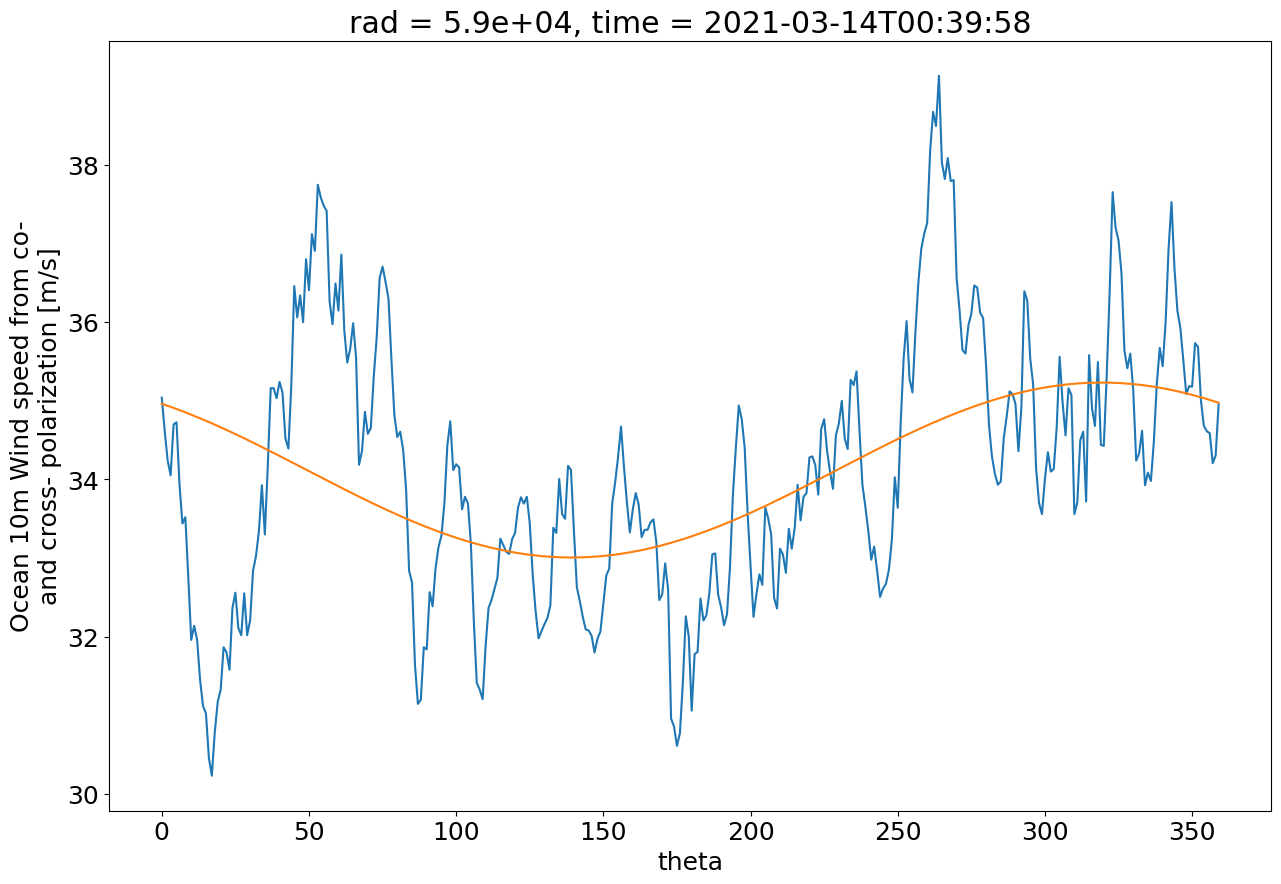

In [10]:
rad = 1.8 * ds.rmx
dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()

a, phi, c = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
print(a) 
plt.plot(dsp.theta, wn1(np.deg2rad(dsp.theta), a, phi, c))

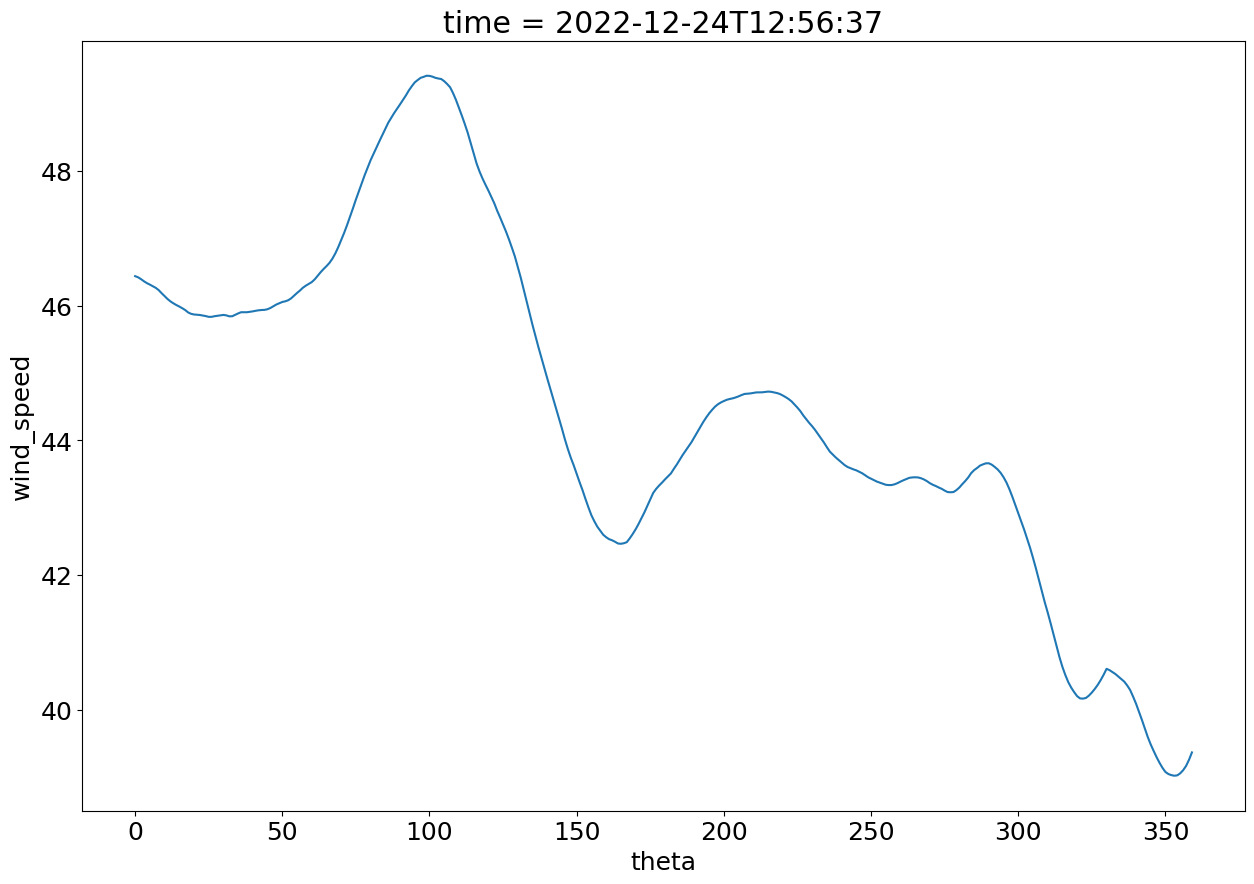

In [18]:
dsp.sel(rad=slice(rad - 3000, rad + 3000)).wind_speed.mean(dim='rad', skipna=True).rolling(theta=60, center=True, min_periods=2).mean().plot()